In [10]:
# STEP 1: Import and Load Data Again
from sklearn.datasets import fetch_california_housing
import pandas as pd

housing = fetch_california_housing(as_frame=True)
df = housing.frame  # STEP 1: Import and Load Data Again



In [12]:
# STEP 2: Add New Feature(s)
df["rooms_per_household"] = df["AveRooms"] / df["AveOccup"]


In [13]:
X = df.drop("MedHouseVal", axis=1)
y = df["MedHouseVal"]


In [14]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# List of numeric columns
num_features = X.select_dtypes(include=["float64", "int64"]).columns

# Pipeline for numeric features
num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Full preprocessing
full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_features)
])

# Transform data
X_prepared = full_pipeline.fit_transform(X)


In [15]:
import joblib
joblib.dump(full_pipeline, "preprocessing_pipeline.pkl")


['preprocessing_pipeline.pkl']

In [16]:
print(X_prepared.shape)


(20640, 9)


In [17]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

lin_reg = LinearRegression()
tree_reg = DecisionTreeRegressor(random_state=42)
forest_reg = RandomForestRegressor(random_state=42)

lin_reg.fit(X_prepared, y)
tree_reg.fit(X_prepared, y)
forest_reg.fit(X_prepared, y)


RandomForestRegressor(random_state=42)

In [25]:
from sklearn.metrics import root_mean_squared_error

def evaluate_model(name, model, X, y):
    predictions = model.predict(X)
    rmse = root_mean_squared_error(y, predictions)
    mae = mean_absolute_error(y, predictions)
    return {
        "Model": name,
        "RMSE": round(rmse, 2),
        "MAE": round(mae, 2)
    }

results = []

for name, model in [
    ("Linear Regression", lin_reg),
    ("Decision Tree", tree_reg),
    ("Random Forest", forest_reg)
]:
    results.append(evaluate_model(name, model, X_prepared, y))

# Display results as a DataFrame
import pandas as pd
results_df = pd.DataFrame(results)
print(results_df)


               Model  RMSE   MAE
0  Linear Regression  0.69  0.49
1      Decision Tree  0.00  0.00
2      Random Forest  0.19  0.12


In [26]:
from sklearn.model_selection import cross_val_score
import numpy as np

def cross_val_rmse(model, X, y):
    # Get negative RMSE scores
    scores = cross_val_score(model, X, y,
                             scoring="neg_root_mean_squared_error",
                             cv=5)
    return -scores  # Make scores positive


In [27]:
models = {
    "Linear Regression": lin_reg,
    "Decision Tree": tree_reg,
    "Random Forest": forest_reg
}

cv_results = {}

for name, model in models.items():
    scores = cross_val_rmse(model, X_prepared, y)
    cv_results[name] = {
        "Mean RMSE": round(scores.mean(), 2),
        "Std Dev": round(scores.std(), 2)
    }

cv_df = pd.DataFrame(cv_results).T
print(cv_df)


                   Mean RMSE  Std Dev
Linear Regression       0.71     0.05
Decision Tree           0.90     0.05
Random Forest           0.65     0.05


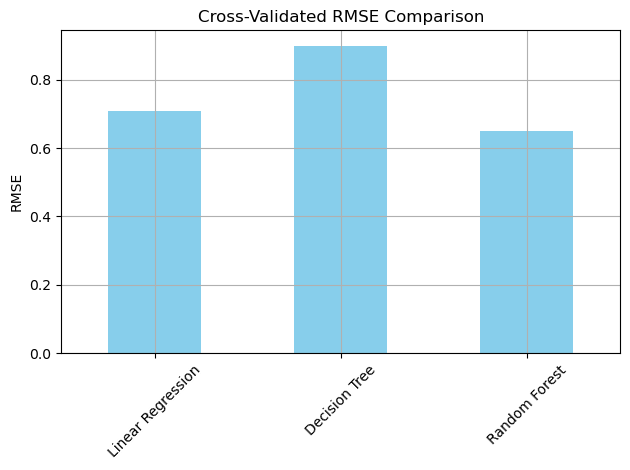

In [28]:
import matplotlib.pyplot as plt

cv_df.plot(kind="bar", y="Mean RMSE", legend=False, color="skyblue")
plt.title("Cross-Validated RMSE Comparison")
plt.ylabel("RMSE")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


In [30]:
import joblib
joblib.dump(forest_reg, "best_model.pkl")


['best_model.pkl']